In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/detectron2 project"

/content/drive/My Drive/detectron2 project


In [3]:
!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 15297 (delta 7), reused 11 (delta 5), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 11.30 MiB/s, done.
Resolving deltas: 100% (11121/11121), done.
Updating files: 100% (820/820), done.


In [4]:
%cd detectron2
!git pull

/content/drive/My Drive/detectron2 project/detectron2
Already up to date.


In [5]:
!pip install .

Processing /content/drive/My Drive/detectron2 project/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6119638 sha256=ce831e584afeca66e422696942bb5a909b9dd48367d3168be19a85be9de4b723
  Stored in directory: /tmp/pip-ephem-wheel-cache-itogz5cm/wheels/07/79/78/526946f6f4c84aad511c3acdb1843c1085f5864c0eb85e622d
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=6ff2fe13fbbec

In [6]:
import math
import os
from os import walk
import numpy as np
import random
import torch
import re

import argparse
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tabulate import tabulate
import cv2
import json

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import *
from detectron2.utils.visualizer import ColorMode
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_backbone
from detectron2.modeling.poolers import ROIPooler
from detectron2.structures import *
from torch.nn import functional as F
from torchvision import transforms
from detectron2.structures import ImageList
import fvcore
from statistics import median

from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

In [7]:
def countAnnotations(dataset):
    nOfItems = 0
    for e in dataset:
        nOfItems += len(e["annotations"])
    return nOfItems

In [8]:
register_coco_instances("keypoint_dataset_train", {},  \
                        r"/content/drive/My Drive/Dataset/detections_keypoints_segmentations_train.json", \
                            r"/content/drive/My Drive/Dataset/dataset_train/data")
register_coco_instances("keypoint_dataset_val", {}, \
                        r"/content/drive/My Drive/Dataset/detections_keypoints_segmentations_valid.json", \
                            r"/content/drive/My Drive/Dataset/dataset_valid/data")
register_coco_instances("keypoint_dataset_test", {}, \
                        r"/content/drive/My Drive/Dataset/detections_keypoints_segmentations_test.json", \
                            r"/content/drive/My Drive/Dataset/dataset_test/data")

In [9]:
keypoint_names = [
    "nose",
    "left_eye", "right_eye",
    "left_ear", "right_ear",
    "left_shoulder", "right_shoulder",
    "left_elbow", "right_elbow",
    "left_wrist", "right_wrist",
    "left_hip", "right_hip",
    "left_knee", "right_knee",
    "left_ankle", "right_ankle"
]

keypoint_flip_map = [
    ("left_eye", "right_eye"),
    ("left_ear", "right_ear"),
    ("left_shoulder", "right_shoulder"),
    ("left_elbow", "right_elbow"),
    ("left_wrist", "right_wrist"),
    ("left_hip", "right_hip"),
    ("left_knee", "right_knee"),
    ("left_ankle", "right_ankle")
]

keypoint_connection_rules = [
    ['left_ankle', 'left_knee', (0, 0, 255)], ['left_knee', 'left_hip', (0, 0, 255)], ['right_ankle', 'right_knee', (0, 0, 255)],
    ['right_knee', 'right_hip', (0, 0, 255)], ['left_hip', 'right_hip', (0, 0, 255)], ['left_shoulder', 'left_hip', (0, 0, 255)],
    ['right_shoulder', 'right_hip', (0, 0, 255)], ['left_shoulder', 'right_shoulder', (0, 0, 255)], ['left_shoulder', 'left_elbow', (0, 0, 255)],
    ['right_shoulder', 'right_elbow', (0, 0, 255)], ['left_elbow', 'left_wrist', (0, 0, 255)], ['right_elbow', 'right_wrist', (0, 0, 255)],
    ['left_eye', 'right_eye', (0, 0, 255)], ['nose', 'left_eye', (0, 0, 255)], ['nose', 'right_eye', (0, 0, 255)], ['left_eye', 'left_ear', (0, 0, 255)],
    ['right_eye', 'right_ear', (0, 0, 255)], ['left_ear', 'left_shoulder', (0, 0, 255)], ['right_ear', 'right_shoulder', (0, 0, 255)]
]

In [10]:
MetadataCatalog.get("keypoint_dataset_train").thing_classes = ["person"]
MetadataCatalog.get("keypoint_dataset_train").keypoint_names = keypoint_names
MetadataCatalog.get("keypoint_dataset_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("keypoint_dataset_train").keypoint_connection_rules = keypoint_connection_rules
#MetadataCatalog.get("keypoint_dataset_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("keypoint_dataset_train").evaluator_type="coco"

MetadataCatalog.get("keypoint_dataset_val").thing_classes = ["person"]
MetadataCatalog.get("keypoint_dataset_val").keypoint_names = keypoint_names
MetadataCatalog.get("keypoint_dataset_val").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("keypoint_dataset_val").keypoint_connection_rules = keypoint_connection_rules
#MetadataCatalog.get("keypoint_dataset_val").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("keypoint_dataset_val").evaluator_type="coco"

MetadataCatalog.get("keypoint_dataset_test").thing_classes = ["person"]
MetadataCatalog.get("keypoint_dataset_test").keypoint_names = keypoint_names
MetadataCatalog.get("keypoint_dataset_test").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("keypoint_dataset_test").keypoint_connection_rules = keypoint_connection_rules
#MetadataCatalog.get("keypoint_dataset_test").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("keypoint_dataset_test").evaluator_type="coco"

In [11]:
keypoint_train_metadata = MetadataCatalog.get("keypoint_dataset_train")

In [12]:
keypoint_dataset_train = DatasetCatalog.get("keypoint_dataset_train")
keypoint_dataset_val = DatasetCatalog.get("keypoint_dataset_val")
keypoint_dataset_test = DatasetCatalog.get("keypoint_dataset_test")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [13]:
print(f"The dataset training contains {countAnnotations(keypoint_dataset_train)} annotations.")
print(f"The dataset validation contains {countAnnotations(keypoint_dataset_val)} annotations.")
print(f"The dataset test contains {countAnnotations(keypoint_dataset_test)} annotations.")

The dataset training contains 7923 annotations.
The dataset validation contains 1146 annotations.
The dataset test contains 2215 annotations.


In [14]:
print("Images in training dataset: ", len(keypoint_dataset_train))
print("Images in validation dataset: ", len(keypoint_dataset_val))
print("Images in test dataset: ", len(keypoint_dataset_test))

Images in training dataset:  3557
Images in validation dataset:  508
Images in test dataset:  1016


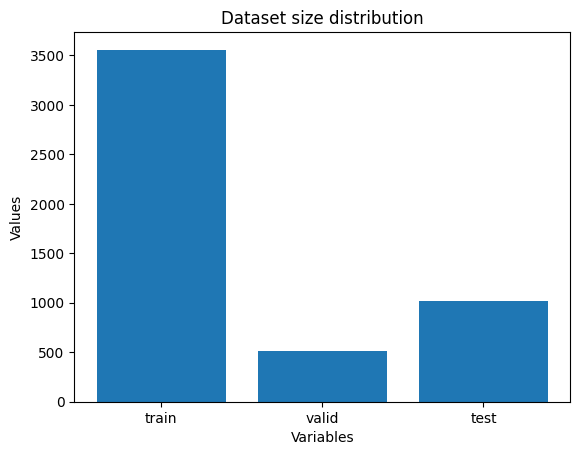

In [15]:
x = ['train', 'valid', 'test']
y = [len(keypoint_dataset_train), len(keypoint_dataset_val), len(keypoint_dataset_test)]

plt.bar(x, y)
plt.title('Dataset size distribution')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

# Data Visualization
* It's also very easy to visualize prepared training dataset with detectron2.
* It provides Visualizer class, we can use it to draw an image with mask and bounding box as following.

In [16]:
for d in random.sample(keypoint_dataset_train, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=keypoint_train_metadata)
    out = visualizer.draw_dataset_dict(d)
    figure(figsize=(16, 12), dpi=72)
    imgplot = plt.imshow(out.get_image())
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
def plotObjectAreaDistribution(dataset):
    smallAreas = []
    largeAreas = []
    for s in keypoint_dataset_train:
        for a in s['annotations']:
            _, _, width, height = a['bbox']
            area = width*height
            if area < 100000:
                smallAreas.append(area)
            else:
                largeAreas.append(area)

    f, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].set_title('Area distribution of small objects: ' + str(len(smallAreas)))
    ax[0].hist(smallAreas, bins=50)
    ax[1].set_title('Area distribution of large objects: ' + str(len(largeAreas)))
    ax[1].hist(largeAreas, bins=50)
    plt.show()

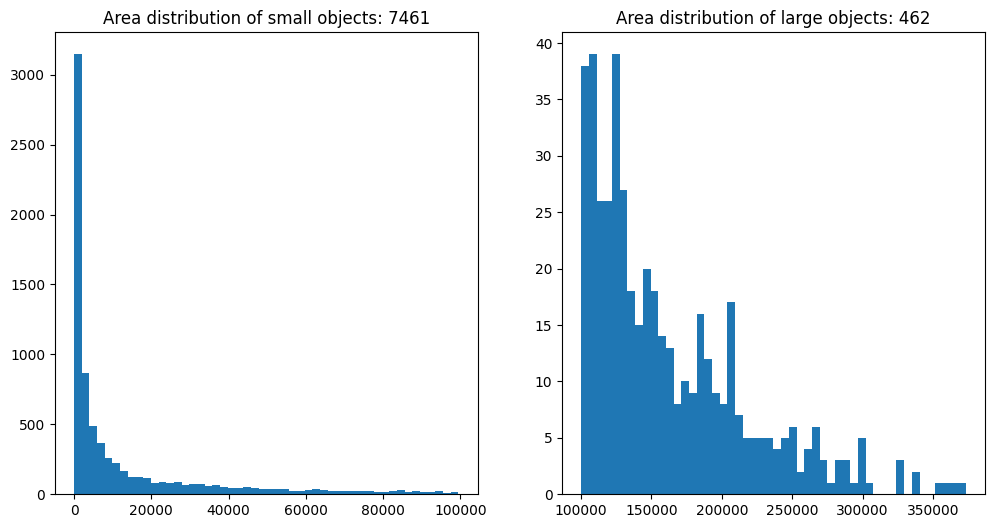

In [18]:
plotObjectAreaDistribution(keypoint_dataset_train)

In [19]:
def plotMedianObjectSizes(dataset, metadata):
    # calculate areas of all objects in categories
    categories = {}
    for s in dataset:
        for a in s['annotations']:
            _, _, width, height = a['bbox']
            cat = a['category_id']
            area = width*height
            if not cat in categories:
                categories[cat] = []
            categories[cat].append(area)

    # Get mapping class name -> category id
    classes = {}
    for i in range(len(metadata.thing_classes)):
        classes[i] = metadata.thing_classes[i]

    # calculate medians
    medians = {}
    for cat_id, areas in categories.items():
        medians[classes[cat_id]] = median(areas)

    # plot medians
    plt.rcdefaults()
    fig, ax = plt.subplots()

    objects = (medians.keys())
    y_pos = np.arange(len(objects))
    medians = np.asarray(list(medians.values()))

    ax.barh(y_pos, medians, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(objects)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Median [square pixels]')
    ax.set_title('Medians of object areas in classes')

    for i, v in enumerate(medians):
        ax.text(v, i, str(v), va='center')

    plt.show()

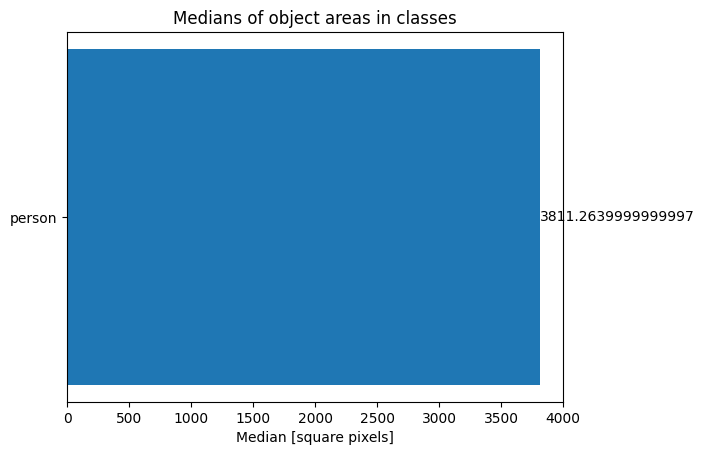

In [20]:
plotMedianObjectSizes(keypoint_dataset_train, MetadataCatalog.get("keypoint_dataset_train"))

In [21]:
keypoint_cfg = get_cfg()
keypoint_cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
keypoint_cfg.DATASETS.TRAIN = ("keypoint_dataset_train",) # note that a tuple has to be passed
keypoint_cfg.DATASETS.TEST = ("keypoint_dataset_val",)  # note that a tuple has to be passed

keypoint_cfg.DATALOADER.NUM_WORKERS = 2

keypoint_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
keypoint_cfg.MODEL.PIXEL_MEAN = [103.530, 116.280, 123.675]

keypoint_cfg.INPUT.MIN_SIZE_TRAIN = (640,480)
keypoint_cfg.INPUT.MAX_SIZE_TRAIN = 1000

keypoint_cfg.MODEL.RPN.NMS_THRESH = 0.9 # non-maximum suppression threshold

keypoint_cfg.SOLVER.IMS_PER_BATCH = 2
keypoint_cfg.SOLVER.BASE_LR = 0.0005
keypoint_cfg.SOLVER.MAX_ITER = 2000
keypoint_cfg.SOLVER.STEPS = []

keypoint_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
keypoint_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
keypoint_cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 17
keypoint_cfg.MODEL.KEYPOINT_ON = True

keypoint_cfg.TEST.EVAL_PERIOD = 500

keypoint_cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((17, 1), dtype=float).tolist()

In [22]:
model = build_model(keypoint_cfg)
model.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [23]:
model.backbone

FPN(
  (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (top_block): LastLevelMaxPool()
  (bottom_up): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1)

In [24]:
model.backbone.bottom_up.output_shape()

{'res2': ShapeSpec(channels=256, height=None, width=None, stride=4),
 'res3': ShapeSpec(channels=512, height=None, width=None, stride=8),
 'res4': ShapeSpec(channels=1024, height=None, width=None, stride=16),
 'res5': ShapeSpec(channels=2048, height=None, width=None, stride=32)}

In [25]:
model.backbone.bottom_up.output_shape()['res5']

ShapeSpec(channels=2048, height=None, width=None, stride=32)

In [26]:
keypoint_species = {}
for i in range(len(keypoint_train_metadata.thing_classes)):
    keypoint_species[i] = keypoint_train_metadata.thing_classes[i]
print(keypoint_species)

{0: 'person'}


In [27]:
model.backbone.fpn_lateral5

Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))

In [28]:
model.backbone.output_shape()

{'p2': ShapeSpec(channels=256, height=None, width=None, stride=4),
 'p3': ShapeSpec(channels=256, height=None, width=None, stride=8),
 'p4': ShapeSpec(channels=256, height=None, width=None, stride=16),
 'p5': ShapeSpec(channels=256, height=None, width=None, stride=32),
 'p6': ShapeSpec(channels=256, height=None, width=None, stride=64)}

In [29]:
model.backbone.top_block

LastLevelMaxPool()

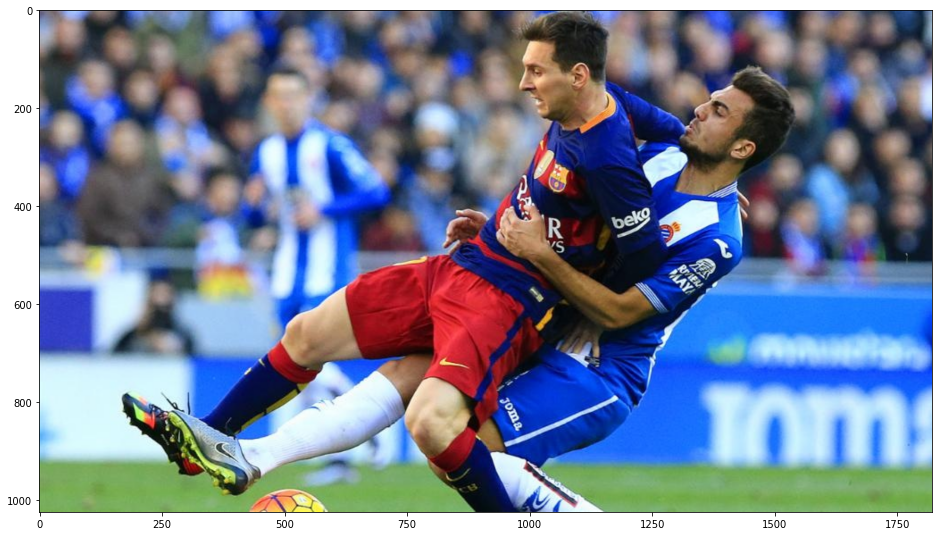

In [30]:
image_file = "/content/drive/My Drive/Dataset/005064.jpg"
tensors = []
image = cv2.imread(image_file)

width = int(image.shape[1] * (1024/image.shape[0]))
height = 1024
dim = (width, height)
image_rs = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
img_rs_rgb = cv2.cvtColor(image_rs, cv2.COLOR_BGR2RGB)

tran = transforms.ToTensor()
tensors.append(tran(image_rs).type(torch.cuda.FloatTensor))

figure(figsize=(16, 12), dpi=72)
img_rgb = cv2.cvtColor(image_rs, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(img_rgb)
plt.show()

images = ImageList.from_tensors(tensors)

In [31]:
featuresResNet = model.backbone.bottom_up.forward(images.tensor)

In [32]:
def plotFeatureMaps(features, channel):
    keys = features.keys()
    for k in keys:
        t = features[k][0, channel:channel+1, :, :] # Get rid of first dimension (batch) and take first channel of feature map

        # Normalize feature map between 0 and 255
        t += t.min()*-1
        normalizedTensor = F.normalize(t.detach())
        m = normalizedTensor.max()
        normalizedTensor *= 255*(1/m)

        display_grid = normalizedTensor.permute(1, 2, 0)
        plt.imshow( display_grid.cpu(), aspect='auto', cmap='viridis')
        plt.title(k)
        plt.show()

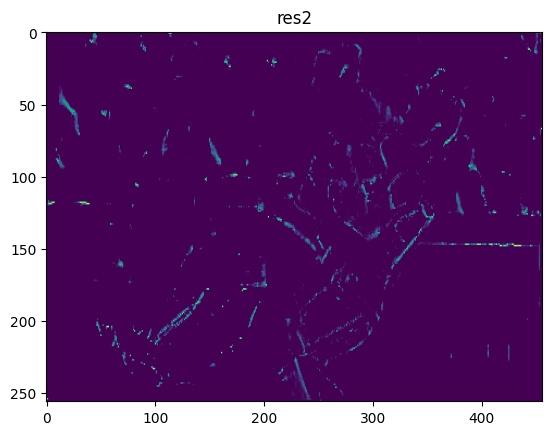

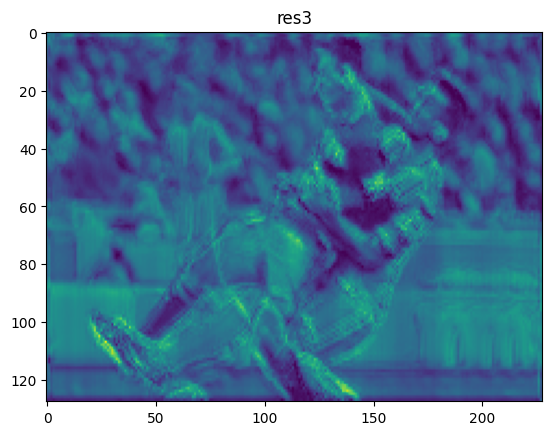

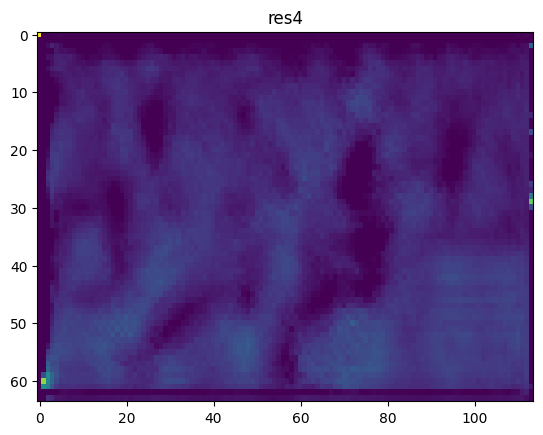

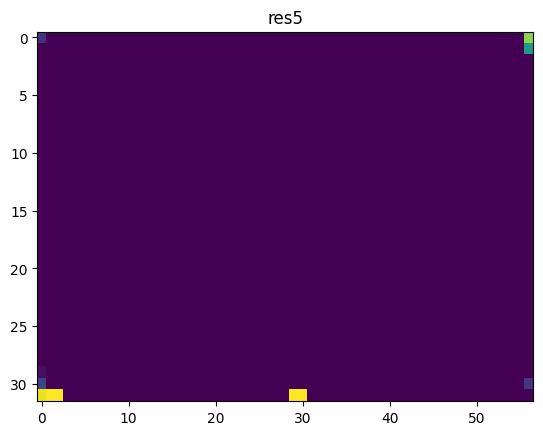

In [33]:
plotFeatureMaps(featuresResNet, 0)

In [34]:
features = model.backbone.forward(images.tensor)

In [35]:
for key, value in features.items():
    print(key, value.shape)

p2 torch.Size([1, 256, 256, 456])
p3 torch.Size([1, 256, 128, 228])
p4 torch.Size([1, 256, 64, 114])
p5 torch.Size([1, 256, 32, 57])
p6 torch.Size([1, 256, 16, 29])


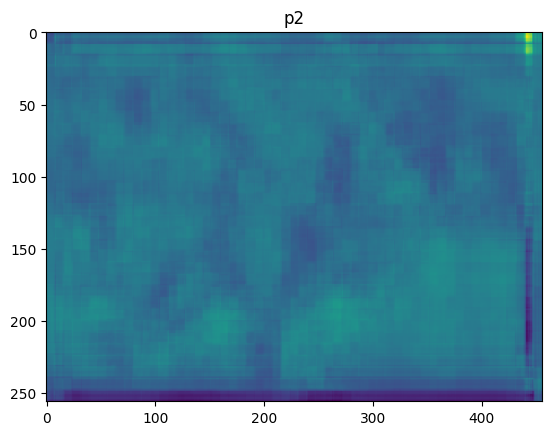

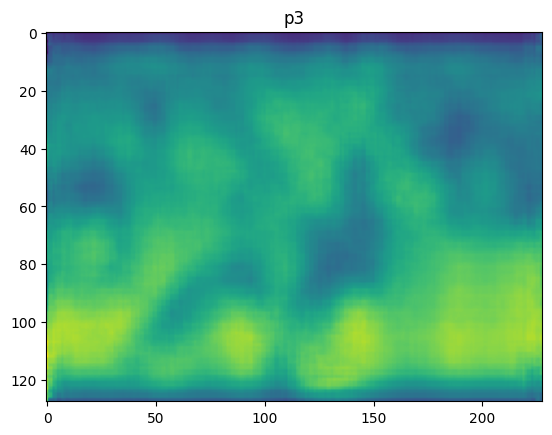

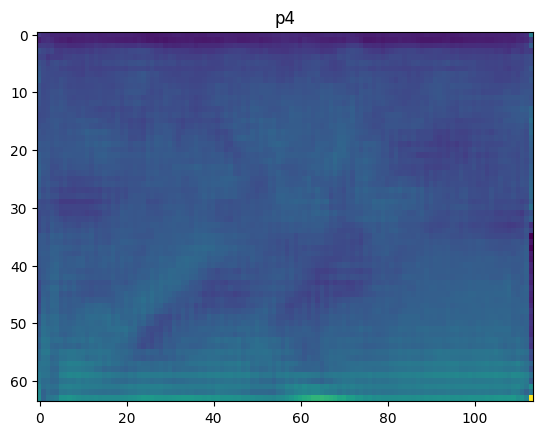

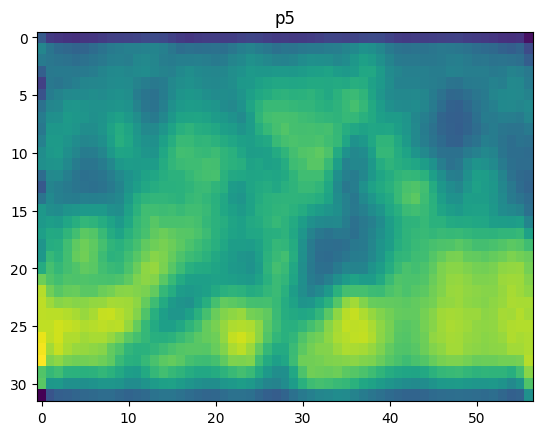

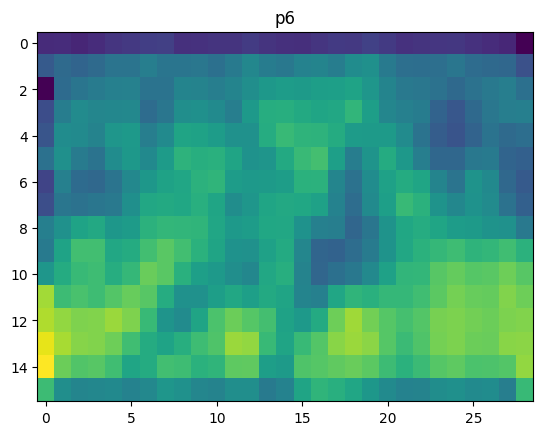

In [36]:
plotFeatureMaps(features, 0)

In [37]:
model.proposal_generator

RPN(
  (rpn_head): StandardRPNHead(
    (conv): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation): ReLU()
    )
    (objectness_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (anchor_deltas): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (anchor_generator): DefaultAnchorGenerator(
    (cell_anchors): BufferList()
  )
)

In [38]:
proposals, _ = model.proposal_generator.forward(images, features)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


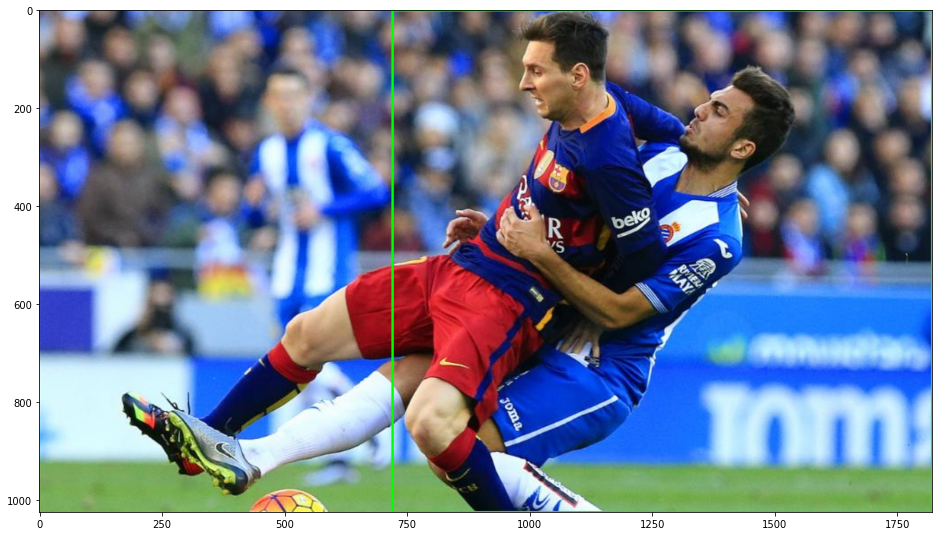

In [39]:
boxes = proposals[0].get_fields()['proposal_boxes']
for b in boxes:
    topLeft = (int(b[0].detach().cpu()), int(b[1].detach().cpu()))
    bottomRight = (int(b[2].detach().cpu()), int(b[3].detach().cpu()))
    cv2.rectangle(img_rgb, (topLeft), (bottomRight), (0,255,0), 3)
figure(figsize=(16, 12), dpi=72)
imgplot = plt.imshow(img_rgb)
plt.show()

In [40]:
model.roi_heads

StandardROIHeads(
  (box_pooler): ROIPooler(
    (level_poolers): ModuleList(
      (0): ROIAlign(output_size=(7, 7), spatial_scale=0.25, sampling_ratio=0, aligned=True)
      (1): ROIAlign(output_size=(7, 7), spatial_scale=0.125, sampling_ratio=0, aligned=True)
      (2): ROIAlign(output_size=(7, 7), spatial_scale=0.0625, sampling_ratio=0, aligned=True)
      (3): ROIAlign(output_size=(7, 7), spatial_scale=0.03125, sampling_ratio=0, aligned=True)
    )
  )
  (box_head): FastRCNNConvFCHead(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=12544, out_features=1024, bias=True)
    (fc_relu1): ReLU()
    (fc2): Linear(in_features=1024, out_features=1024, bias=True)
    (fc_relu2): ReLU()
  )
  (box_predictor): FastRCNNOutputLayers(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=4, bias=True)
  )
  (keypoint_pooler): ROIPooler(
    (level_poolers): ModuleList(
      (0): ROIAlign(outpu

In [41]:
instances, _ = model.roi_heads.forward(images, features, proposals)

In [42]:
def printInstancesPerClass(dataset, instance_dict):
    nOfInstances = {}
    for key, _ in instance_dict.items():
        nOfInstances[key] = 0

    for e in dataset:
        for a in e["annotations"]:
            id = a["category_id"]
            val = nOfInstances[id]
            nOfInstances[id] = val+1

    instances_per_class = {}
    for i in range(0, len(instance_dict)):
        instances_per_class[instance_dict[i]] = nOfInstances[i]

    s = sorted(instances_per_class.items(), key=lambda x:x[1], reverse=True)
    print(tabulate(s, headers=["Species name", "#"]))

In [43]:
printInstancesPerClass(keypoint_dataset_train, keypoint_species)

Species name       #
--------------  ----
person          7923


In [44]:
printInstancesPerClass(keypoint_dataset_val, keypoint_species)

Species name       #
--------------  ----
person          1146


In [45]:
printInstancesPerClass(keypoint_dataset_test, keypoint_species)

Species name       #
--------------  ----
person          2215


In [46]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced


    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [47]:
from detectron2.data import transforms as T
from detectron2.evaluation import COCOEvaluator

augs = [
    T.RandomBrightness(0.9, 1.1),
    T.RandomFlip(prob=0.5),
    T.RandomCrop("absolute", (640, 640)),
    T.RandomBrightness(0.9, 1.1),
    T.RandomContrast(0.9, 1.1),
    T.RandomSaturation(0.9, 1.1),
    T.RandomLighting(0.9),
    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
    T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
    ]
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
        keypoint_cfg.TEST.EVAL_PERIOD,
        self.model,
        build_detection_test_loader(
            self.cfg,
            self.cfg.DATASETS.TEST[0],
            #DatasetMapper(self.cfg,True)
            DatasetMapper(self.cfg, is_train=True, augmentations=augs)
        )
        ))
        return hooks
    '''
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=augs)
        return build_detection_train_loader(cfg, mapper=mapper)'''

In [48]:
os.makedirs(keypoint_cfg.OUTPUT_DIR, exist_ok=True)
keypoint_trainer = MyTrainer(keypoint_cfg)
keypoint_trainer.resume_or_load(resume=False)

[12/25 15:05:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_997cc7.pkl: 313MB [00:01, 196MB/s]                           


In [49]:
keypoint_trainer.train()

[12/25 15:05:49 d2.engine.train_loop]: Starting training from iteration 0


/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[12/25 15:06:01 d2.utils.events]:  eta: 0:14:11  iter: 19  total_loss: 3.403  loss_cls: 0.1707  loss_box_reg: 0.1178  loss_keypoint: 3.015  loss_rpn_cls: 0.009705  loss_rpn_loc: 0.02668    time: 0.4303  last_time: 0.4397  data_time: 0.0359  last_data_time: 0.0039   lr: 9.9905e-06  max_mem: 6284M
[12/25 15:06:13 d2.utils.events]:  eta: 0:14:10  iter: 39  total_loss: 3.309  loss_cls: 0.1487  loss_box_reg: 0.1198  loss_keypoint: 3.048  loss_rpn_cls: 0.009922  loss_rpn_loc: 0.01971    time: 0.4229  last_time: 0.4647  data_time: 0.0072  last_data_time: 0.0042   lr: 1.998e-05  max_mem: 6286M
[12/25 15:06:21 d2.utils.events]:  eta: 0:14:03  iter: 59  total_loss: 3.326  loss_cls: 0.1851  loss_box_reg: 0.1954  loss_keypoint: 3.007  loss_rpn_cls: 0.01146  loss_rpn_loc: 0.03172    time: 0.4222  last_time: 0.4357  data_time: 0.0114  last_data_time: 0.0098   lr: 2.997e-05  max_mem: 6287M
[12/25 15:06:30 d2.utils.events]:  eta: 0:13:55  iter: 79  total_loss: 3.433  loss_cls: 0.1775  loss_box_reg: 0.

/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axi

[12/25 15:11:12 detectron2]: Loss on Validation  done 11/508. 0.0001 s / img. ETA=0:00:57


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:11:17 detectron2]: Loss on Validation  done 48/508. 0.0001 s / img. ETA=0:01:01


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:11:22 detectron2]: Loss on Validation  done 77/508. 0.0001 s / img. ETA=0:01:04


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:11:27 detectron2]: Loss on Validation  done 116/508. 0.0001 s / img. ETA=0:00:55


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:11:32 detectron2]: Loss on Validation  done 154/508. 0.0001 s / img. ETA=0:00:49


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:11:37 detectron2]: Loss on Validation  done 181/508. 0.0001 s / img. ETA=0:00:48


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:11:42 detectron2]: Loss on Validation  done 217/508. 0.0001 s / img. ETA=0:00:42


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:11:47 detectron2]: Loss on Validation  done 255/508. 0.0001 s / img. ETA=0:00:36


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:11:52 detectron2]: Loss on Validation  done 284/508. 0.0001 s / img. ETA=0:00:33


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:11:57 detectron2]: Loss on Validation  done 322/508. 0.0001 s / img. ETA=0:00:27


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:12:02 detectron2]: Loss on Validation  done 360/508. 0.0001 s / img. ETA=0:00:21


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:12:07 detectron2]: Loss on Validation  done 388/508. 0.0001 s / img. ETA=0:00:17


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:12:13 detectron2]: Loss on Validation  done 425/508. 0.0001 s / img. ETA=0:00:12


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:12:18 detectron2]: Loss on Validation  done 462/508. 0.0001 s / img. ETA=0:00:06


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:12:23 detectron2]: Loss on Validation  done 491/508. 0.0001 s / img. ETA=0:00:02


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:12:25 d2.utils.events]:  eta: 0:11:39  iter: 499  total_loss: 3.043  loss_cls: 0.1031  loss_box_reg: 0.07909  loss_keypoint: 2.714  loss_rpn_cls: 0.008443  loss_rpn_loc: 0.01035  validation_loss: 3.134    time: 0.4487  last_time: 0.4554  data_time: 0.0084  last_data_time: 0.0117   lr: 0.00024975  max_mem: 6289M


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[12/25 15:12:34 d2.utils.events]:  eta: 0:11:27  iter: 519  total_loss: 2.925  loss_cls: 0.1268  loss_box_reg: 0.1459  loss_keypoint: 2.678  loss_rpn_cls: 0.007143  loss_rpn_loc: 0.00835  validation_loss: 3.134    time: 0.4477  last_time: 0.5017  data_time: 0.0072  last_data_time: 0.0147   lr: 0.00025974  max_mem: 6289M
[12/25 15:12:43 d2.utils.events]:  eta: 0:11:18  iter: 539  total_loss: 3.391  loss_cls: 0.1726  loss_box_reg: 0.1554  loss_keypoint: 3.055  loss_rpn_cls: 0.004234  loss_rpn_loc: 0.01018  validation_loss: 3.134    time: 0.4481  last_time: 0.3932  data_time: 0.0078  last_data_time: 0.0065   lr: 0.00026973  max_mem: 6289M
[12/25 15:12:52 d2.utils.events]:  eta: 0:11:10  iter: 559  total_loss: 3.416  loss_cls: 0.1931  loss_box_reg: 0.1836  loss_keypoint: 2.968  loss_rpn_cls: 0.009548  loss_rpn_loc: 0.02357  validation_loss: 3.134    time: 0.4483  last_time: 0.4710  data_time: 0.0076  last_data_time: 0.0045   lr: 0.00027972  max_mem: 6289M
[12/25 15:13:01 d2.utils.events]: 

/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axi

[12/25 15:17:44 detectron2]: Loss on Validation  done 11/508. 0.0001 s / img. ETA=0:01:20


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:17:49 detectron2]: Loss on Validation  done 40/508. 0.0002 s / img. ETA=0:01:20


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:17:54 detectron2]: Loss on Validation  done 76/508. 0.0001 s / img. ETA=0:01:07


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:17:59 detectron2]: Loss on Validation  done 109/508. 0.0001 s / img. ETA=0:01:01


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:05 detectron2]: Loss on Validation  done 139/508. 0.0002 s / img. ETA=0:00:58


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:10 detectron2]: Loss on Validation  done 175/508. 0.0001 s / img. ETA=0:00:51


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:15 detectron2]: Loss on Validation  done 208/508. 0.0002 s / img. ETA=0:00:46


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:20 detectron2]: Loss on Validation  done 238/508. 0.0002 s / img. ETA=0:00:42


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:25 detectron2]: Loss on Validation  done 274/508. 0.0002 s / img. ETA=0:00:36


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:30 detectron2]: Loss on Validation  done 306/508. 0.0001 s / img. ETA=0:00:31


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:35 detectron2]: Loss on Validation  done 336/508. 0.0001 s / img. ETA=0:00:26


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:40 detectron2]: Loss on Validation  done 373/508. 0.0001 s / img. ETA=0:00:20


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:45 detectron2]: Loss on Validation  done 405/508. 0.0001 s / img. ETA=0:00:15


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:50 detectron2]: Loss on Validation  done 436/508. 0.0001 s / img. ETA=0:00:11


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:18:55 detectron2]: Loss on Validation  done 471/508. 0.0001 s / img. ETA=0:00:05


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:19:00 detectron2]: Loss on Validation  done 503/508. 0.0001 s / img. ETA=0:00:00


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[12/25 15:19:01 d2.utils.events]:  eta: 0:07:48  iter: 999  total_loss: 2.942  loss_cls: 0.1287  loss_box_reg: 0.08994  loss_keypoint: 2.694  loss_rpn_cls: 0.005615  loss_rpn_loc: 0.01313  validation_loss: 3.072    time: 0.4525  last_time: 0.5441  data_time: 0.0091  last_data_time: 0.0244   lr: 0.0004995  max_mem: 6289M
[12/25 15:19:10 d2.utils.events]:  eta: 0:07:39  iter: 1019  total_loss: 3.417  loss_cls: 0.1298  loss_box_reg: 0.1539  loss_keypoint: 3.127  loss_rpn_cls: 0.006811  loss_rpn_loc: 0.01343  validation_loss: 3.072    time: 0.4524  last_time: 0.4944  data_time: 0.0099  last_data_time: 0.0070   lr: 0.0005  max_mem: 6289M
[12/25 15:19:19 d2.utils.events]:  eta: 0:07:30  iter: 1039  total_loss: 3.111  loss_cls: 0.1133  loss_box_reg: 0.1292  loss_keypoint: 2.894  loss_rpn_cls: 0.007288  loss_rpn_loc: 0.007942  validation_loss: 3.072    time: 0.4523  last_time: 0.3613  data_time: 0.0128  last_data_time: 0.0150   lr: 0.0005  max_mem: 6289M
[12/25 15:19:28 d2.utils.events]:  eta:

/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axi

[12/25 15:24:21 detectron2]: Loss on Validation  done 11/508. 0.0001 s / img. ETA=0:01:01


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:24:26 detectron2]: Loss on Validation  done 37/508. 0.0001 s / img. ETA=0:01:24


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:24:31 detectron2]: Loss on Validation  done 71/508. 0.0001 s / img. ETA=0:01:12


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:24:36 detectron2]: Loss on Validation  done 106/508. 0.0001 s / img. ETA=0:01:03


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:24:41 detectron2]: Loss on Validation  done 133/508. 0.0001 s / img. ETA=0:01:01


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:24:46 detectron2]: Loss on Validation  done 168/508. 0.0001 s / img. ETA=0:00:54


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:24:51 detectron2]: Loss on Validation  done 203/508. 0.0001 s / img. ETA=0:00:48


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:24:56 detectron2]: Loss on Validation  done 228/508. 0.0001 s / img. ETA=0:00:45


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:25:01 detectron2]: Loss on Validation  done 263/508. 0.0001 s / img. ETA=0:00:39


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:25:06 detectron2]: Loss on Validation  done 298/508. 0.0001 s / img. ETA=0:00:33


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:25:11 detectron2]: Loss on Validation  done 324/508. 0.0001 s / img. ETA=0:00:29


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:25:17 detectron2]: Loss on Validation  done 359/508. 0.0001 s / img. ETA=0:00:23


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:25:22 detectron2]: Loss on Validation  done 394/508. 0.0001 s / img. ETA=0:00:18


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:25:27 detectron2]: Loss on Validation  done 420/508. 0.0001 s / img. ETA=0:00:14


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:25:32 detectron2]: Loss on Validation  done 455/508. 0.0001 s / img. ETA=0:00:08


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:25:37 detectron2]: Loss on Validation  done 490/508. 0.0001 s / img. ETA=0:00:02


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:25:41 d2.utils.events]:  eta: 0:03:55  iter: 1499  total_loss: 3.169  loss_cls: 0.1286  loss_box_reg: 0.1483  loss_keypoint: 2.739  loss_rpn_cls: 0.007219  loss_rpn_loc: 0.01371  validation_loss: 3.158    time: 0.4528  last_time: 0.4921  data_time: 0.0114  last_data_time: 0.0036   lr: 0.0005  max_mem: 6289M
[12/25 15:25:50 d2.utils.events]:  eta: 0:03:46  iter: 1519  total_loss: 3.355  loss_cls: 0.1844  loss_box_reg: 0.1852  loss_keypoint: 2.906  loss_rpn_cls: 0.009057  loss_rpn_loc: 0.01492  validation_loss: 3.158    time: 0.4529  last_time: 0.5098  data_time: 0.0085  last_data_time: 0.0069   lr: 0.0005  max_mem: 6289M
[12/25 15:25:59 d2.utils.events]:  eta: 0:03:37  iter: 1539  total_loss: 2.811  loss_cls: 0.08755  loss_box_reg: 0.1234  loss_keypoint: 2.666  loss_rpn_cls: 0.00675  loss_rpn_loc: 0.01046  validation_loss: 3.158    time: 0.4532  last_time: 0.4584  data_time: 0.0131  last_data_time: 0.0052   lr: 0.0005  max_mem: 6289M
[12/25 15:26:09 d2.utils.events]:  eta: 0:0

/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/content/drive/My Drive/detectron2 project/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axi

[12/25 15:29:38 detectron2]: Loss on Validation  done 11/508. 0.0001 s / img. ETA=0:01:02


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:29:43 detectron2]: Loss on Validation  done 45/508. 0.0001 s / img. ETA=0:01:07


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:29:48 detectron2]: Loss on Validation  done 65/508. 0.0001 s / img. ETA=0:01:21


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:29:54 detectron2]: Loss on Validation  done 86/508. 0.0001 s / img. ETA=0:01:24


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:29:59 detectron2]: Loss on Validation  done 114/508. 0.0001 s / img. ETA=0:01:17


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:04 detectron2]: Loss on Validation  done 138/508. 0.0001 s / img. ETA=0:01:13


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:09 detectron2]: Loss on Validation  done 171/508. 0.0001 s / img. ETA=0:01:03


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:14 detectron2]: Loss on Validation  done 204/508. 0.0001 s / img. ETA=0:00:55


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:19 detectron2]: Loss on Validation  done 229/508. 0.0001 s / img. ETA=0:00:51


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:24 detectron2]: Loss on Validation  done 260/508. 0.0001 s / img. ETA=0:00:45


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:29 detectron2]: Loss on Validation  done 293/508. 0.0001 s / img. ETA=0:00:38


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:34 detectron2]: Loss on Validation  done 318/508. 0.0001 s / img. ETA=0:00:34


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:39 detectron2]: Loss on Validation  done 351/508. 0.0001 s / img. ETA=0:00:28


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:44 detectron2]: Loss on Validation  done 384/508. 0.0001 s / img. ETA=0:00:21


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:49 detectron2]: Loss on Validation  done 408/508. 0.0001 s / img. ETA=0:00:17


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:54 detectron2]: Loss on Validation  done 441/508. 0.0001 s / img. ETA=0:00:11


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:30:59 detectron2]: Loss on Validation  done 473/508. 0.0001 s / img. ETA=0:00:06


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:31:05 detectron2]: Loss on Validation  done 498/508. 0.0001 s / img. ETA=0:00:01


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

[12/25 15:31:06 d2.utils.events]:  eta: 0:00:00  iter: 1999  total_loss: 2.933  loss_cls: 0.108  loss_box_reg: 0.09814  loss_keypoint: 2.741  loss_rpn_cls: 0.001717  loss_rpn_loc: 0.007821  validation_loss: 3.275    time: 0.4542  last_time: 0.5036  data_time: 0.0089  last_data_time: 0.0074   lr: 0.0005  max_mem: 6289M
[12/25 15:31:06 d2.engine.hooks]: Overall training speed: 1998 iterations in 0:15:07 (0.4542 s / it)
[12/25 15:31:06 d2.engine.hooks]: Total training time: 0:25:13 (0:10:05 on hooks)
WARNING [12/25 15:31:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/25 15:31:06 d2.data.datasets.coco]: Loaded 508 images in COCO format from /content/drive/My Drive/Dataset/detections_keypoints_segmentations_valid.json
[12/25 15:31:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/25 15:31:06 d2.data.

In [50]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

def plot_losses(cfg):
    experiment_metrics = load_json_arr(cfg.OUTPUT_DIR + '/metrics.json')

    plt.rcParams['figure.figsize'] = [15, 8]
    iterations = []
    train_loss = []
    val_loss = []
    for x in experiment_metrics:
        if ('iteration' in x) and ('total_loss' in x) and ('validation_loss' in x):
            iterations.append(x['iteration'])
            train_loss.append(x['total_loss'])
            val_loss.append(x['validation_loss'])
    plt.plot(
        iterations,
        train_loss)
    plt.plot(
        iterations,
        val_loss)
    plt.legend(['total_loss', 'validation_loss'], loc='upper right')
    plt.title("Training and validation loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

def plot_AP_iterations(cfg):
    experiment_metrics = load_json_arr(cfg.OUTPUT_DIR + '/metrics.json')

    plt.rcParams['figure.figsize'] = [15, 8]
    iterations = []
    ap = []
    ap50 = []
    ap75 = []
    for x in experiment_metrics:
        if ('iteration' in x) and ('bbox/AP' in x) and ('bbox/AP50' in x) and ('bbox/AP75' in x):
            iterations.append(x['iteration'])
            ap.append(x['bbox/AP'])
            ap50.append(x['bbox/AP50'])
            ap75.append(x['bbox/AP75'])
    plt.plot(
        iterations,
        ap)
    plt.plot(
        iterations,
        ap50)
    plt.plot(
        iterations,
        ap75)
    plt.legend(['AP', 'AP50', 'AP75'], loc='upper right')
    plt.title("AP of all classes")
    plt.xlabel("Iteration")
    plt.ylabel("AP")
    plt.show()

def plot_lr(cfg):
    experiment_metrics = load_json_arr(cfg.OUTPUT_DIR + '/metrics.json')

    plt.rcParams['figure.figsize'] = [15, 8]
    iterations = []
    lr = []
    for x in experiment_metrics:
        if ('iteration' in x) and ('lr' in x):
            iterations.append(x['iteration'])
            lr.append(x['lr'])
    plt.plot(
        iterations,
        lr)
    plt.legend(['learning rate'], loc='upper right')
    plt.title("Learning rate during training")
    plt.xlabel("Iteration")
    #plt.ylabel("AP")
    plt.show()

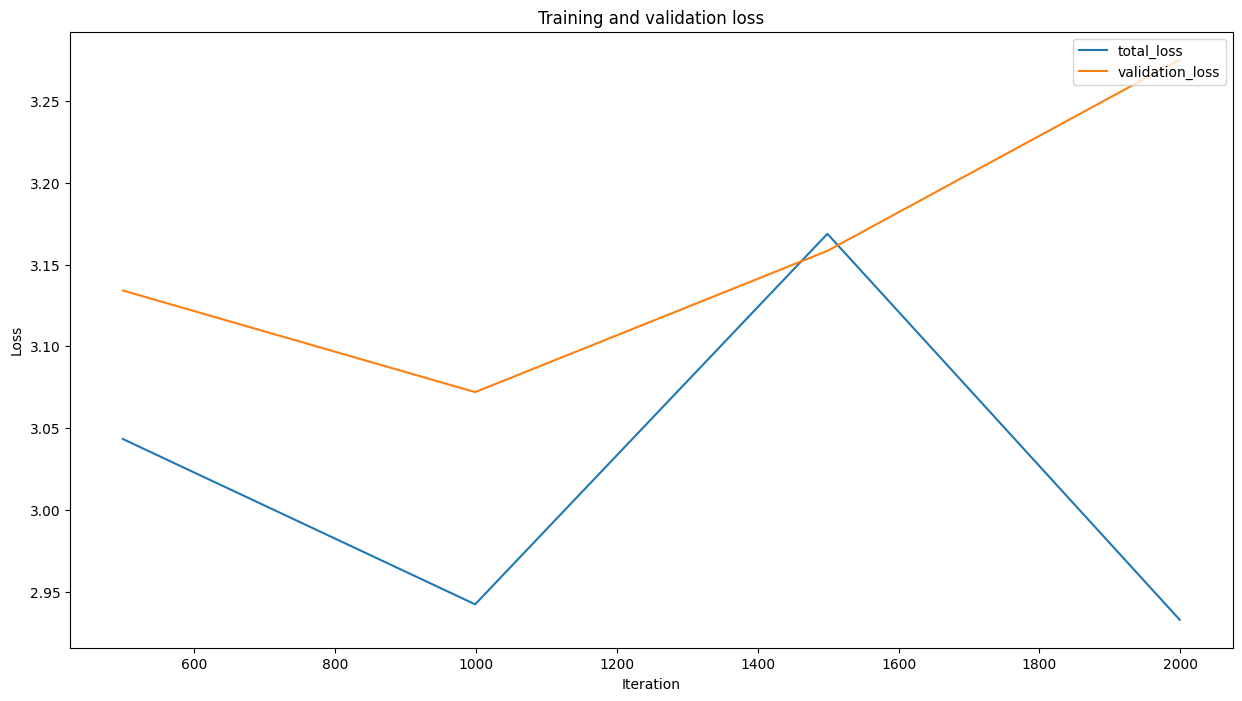

In [51]:
plot_losses(keypoint_cfg)

In [52]:
from detectron2.evaluation import COCOEvaluator

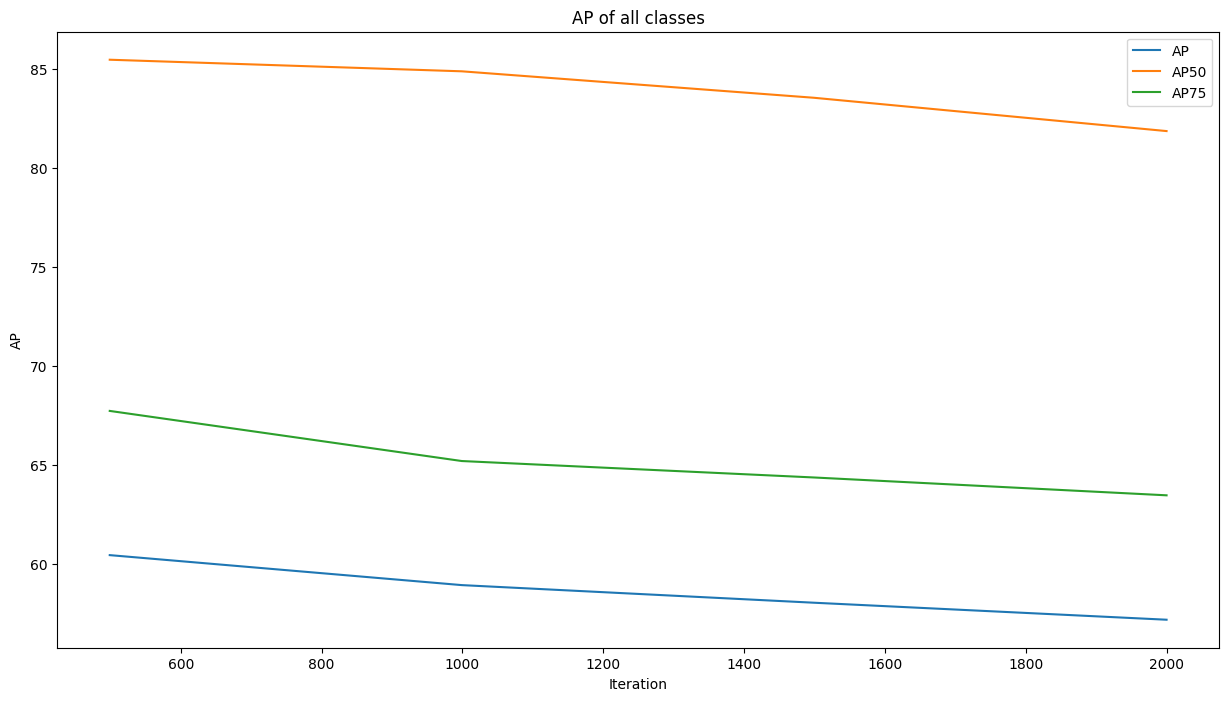

In [53]:
plot_AP_iterations(keypoint_cfg)

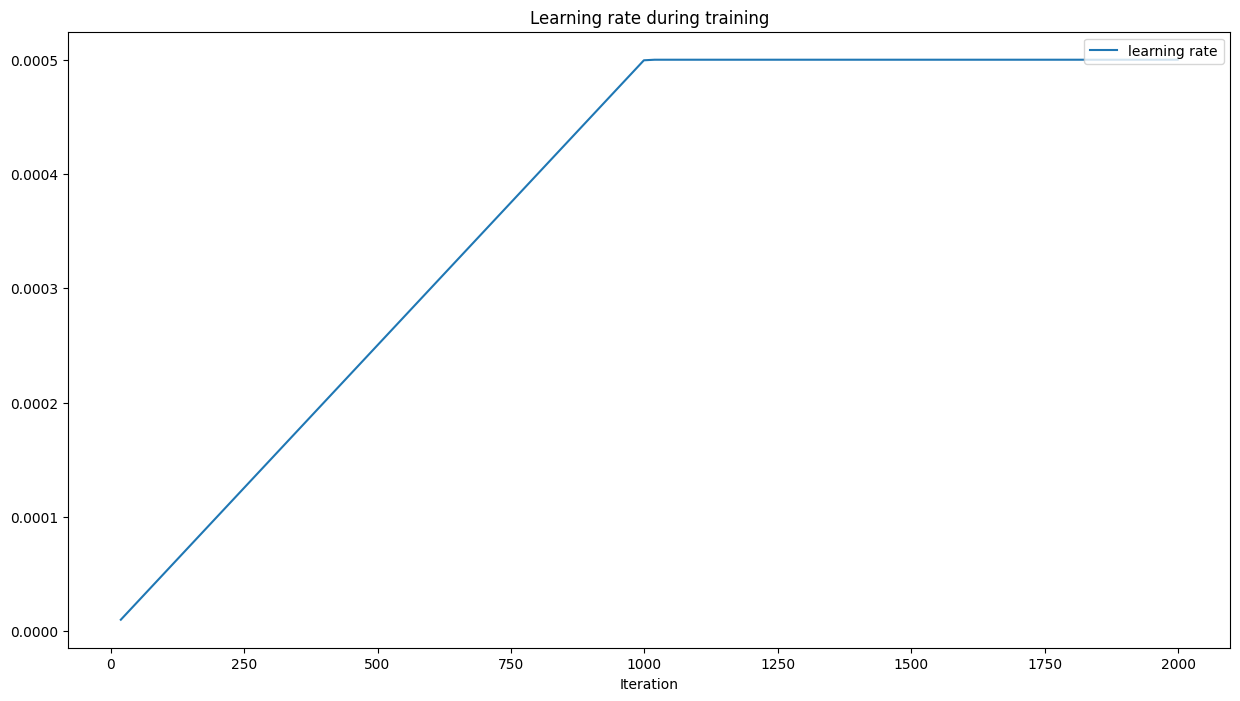

In [54]:
plot_lr(keypoint_cfg)

In [55]:
cocoEval = COCOEvaluator('keypoint_dataset_test', distributed=True, output_dir='./output_keypoint_eval', kpt_oks_sigmas=np.ones((17, 1), dtype=float).tolist())

[12/25 15:32:41 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.


In [56]:
outputs = []
predictor = DefaultPredictor(keypoint_cfg)
for s in keypoint_dataset_test:
    img = cv2.imread(s['file_name'])
    outputs.append(predictor(img))

[12/25 15:32:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl ...


In [57]:
cocoEval.reset()
cocoEval.process(keypoint_dataset_test, outputs)
results = cocoEval.evaluate()

[12/25 15:40:07 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/25 15:40:07 d2.evaluation.coco_evaluation]: Saving results to ./output_keypoint_eval/coco_instances_results.json
[12/25 15:40:07 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.21s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.800
 Average

In [58]:
keypoint_cfg.MODEL.WEIGHTS = os.path.join(keypoint_cfg.OUTPUT_DIR, "model_final.pth")
keypoint_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 # bbox score threshold during inference
keypoint_cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2 # non maximum suppression threshold during inference
keypoint_cfg.MODEL.RPN.NMS_THRESH_TEST = 0.2
keypoint_cfg.DATASETS.TEST = ("keypoint_dataset_test", )
predictor = DefaultPredictor(keypoint_cfg)

for d in random.sample(keypoint_dataset_test, 5):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(img[:, :, ::-1], MetadataCatalog.get("keypoint_dataset_test"))
    outPredicted = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(img[:, :, ::-1], MetadataCatalog.get("keypoint_dataset_test"))
    outOrigin = visualizer.draw_dataset_dict(d)

    f, ax = plt.subplots(2,1, figsize=(32, 24))
    ax[0].set_title('Prediction')
    ax[0].imshow(outPredicted.get_image())
    ax[1].set_title('Ground truth')
    ax[1].imshow(outOrigin.get_image())
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [59]:
experiment_metrics = load_json_arr(keypoint_cfg.OUTPUT_DIR + '/metrics.json')

In [60]:
experiment_metrics

[{'data_time': 0.006727657500022133,
  'eta_seconds': 851.8301797500163,
  'fast_rcnn/cls_accuracy': 0.953125,
  'fast_rcnn/false_negative': 0.0625,
  'fast_rcnn/fg_cls_accuracy': 0.9375,
  'iteration': 19,
  'keypoint_head/num_fg_samples': 7.5,
  'loss_box_reg': 0.11777354404330254,
  'loss_cls': 0.17067424207925797,
  'loss_keypoint': 3.015421748161316,
  'loss_rpn_cls': 0.009705344680696726,
  'loss_rpn_loc': 0.02667933516204357,
  'lr': 9.9905e-06,
  'rank_data_time': 0.006727657500022133,
  'roi_head/num_bg_samples': 24.0,
  'roi_head/num_fg_samples': 8.0,
  'rpn/num_neg_anchors': 227.0,
  'rpn/num_pos_anchors': 29.0,
  'time': 0.43021726250000825,
  'timetest': 12.0,
  'total_loss': 3.40330977877602},
 {'data_time': 0.007153612499990913,
  'eta_seconds': 850.7229521000102,
  'fast_rcnn/cls_accuracy': 0.9453125,
  'fast_rcnn/false_negative': 0.0625,
  'fast_rcnn/fg_cls_accuracy': 0.9375,
  'iteration': 39,
  'keypoint_head/num_fg_samples': 6.75,
  'loss_box_reg': 0.119765687733888

In [61]:
results

OrderedDict([('bbox',
              {'AP': 62.348605091093134,
               'AP50': 88.23339775030414,
               'AP75': 69.80935363601911,
               'APs': 37.58804273805356,
               'APm': 64.22804424957344,
               'APl': 80.0163255162583}),
             ('keypoints',
              {'AP': 98.2021297360808,
               'AP50': 98.2121623654009,
               'AP75': 98.20421579379185,
               'APm': 99.20852633719804,
               'APl': 99.5983998592878})])

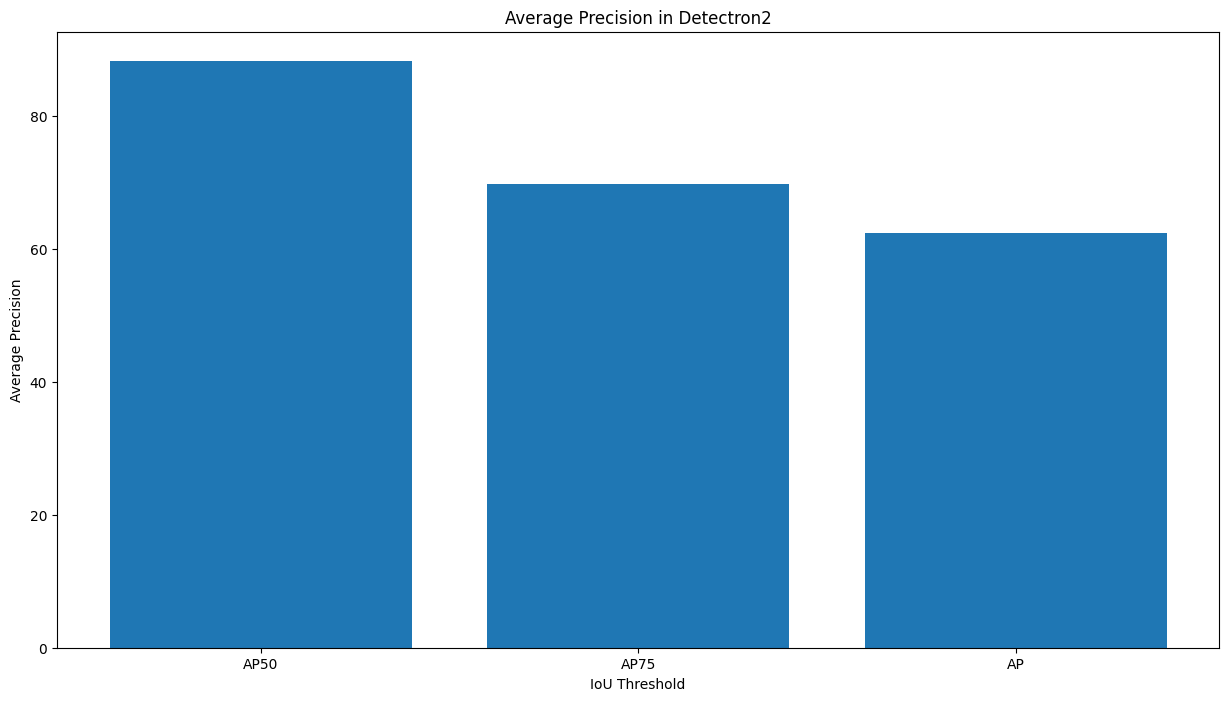

In [62]:
ap_50 = results["bbox"]["AP50"]
ap_75 = results["bbox"]["AP75"]
ap = results["bbox"]["AP"]

# Plot the average precision values as a bar chart
plt.bar(["AP50", "AP75", "AP"], [ap_50, ap_75, ap])
plt.xlabel("IoU Threshold")
plt.ylabel("Average Precision")
plt.title("Average Precision in Detectron2")
plt.show()

In [63]:
from detectron2.evaluation import print_csv_format
print_csv_format(results)


[12/25 15:40:24 d2.evaluation.testing]: copypaste: Task: bbox
[12/25 15:40:24 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/25 15:40:24 d2.evaluation.testing]: copypaste: 62.3486,88.2334,69.8094,37.5880,64.2280,80.0163
[12/25 15:40:24 d2.evaluation.testing]: copypaste: Task: keypoints
[12/25 15:40:24 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APm,APl
[12/25 15:40:24 d2.evaluation.testing]: copypaste: 98.2021,98.2122,98.2042,99.2085,99.5984


In [64]:
keypoints = cocoEval._coco_api.loadAnns(cocoEval._coco_api.getAnnIds())

In [65]:
val_loader = build_detection_test_loader(keypoint_cfg, "keypoint_dataset_test")

from detectron2.evaluation import inference_on_dataset
#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, cocoEval)


WARNING [12/25 15:40:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/25 15:40:24 d2.data.datasets.coco]: Loaded 1016 images in COCO format from /content/drive/My Drive/Dataset/detections_keypoints_segmentations_test.json
[12/25 15:40:24 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 2170         |
|            |              |
[12/25 15:40:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/25 15:40:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/25 15:40:24 d2.data.common]: Serializing 1016 elements to byte tensors and concatenating them all ...
[12/25 15:40:25 d2.data.common]: Serialized dataset takes 1.84 MiB
[12/25 15:40:25 d2.evaluation.eval

OrderedDict([('bbox',
              {'AP': 46.764841135650826,
               'AP50': 63.77178904694239,
               'AP75': 54.06319754945851,
               'APs': 17.510396517793197,
               'APm': 50.709274741302465,
               'APl': 71.14758595541659}),
             ('keypoints',
              {'AP': 88.81130174492434,
               'AP50': 88.81213224033816,
               'AP75': 88.81213224033816,
               'APm': 93.91171413840421,
               'APl': 94.46987328068842})])

In [66]:
results

OrderedDict([('bbox',
              {'AP': 62.348605091093134,
               'AP50': 88.23339775030414,
               'AP75': 69.80935363601911,
               'APs': 37.58804273805356,
               'APm': 64.22804424957344,
               'APl': 80.0163255162583}),
             ('keypoints',
              {'AP': 98.2021297360808,
               'AP50': 98.2121623654009,
               'AP75': 98.20421579379185,
               'APm': 99.20852633719804,
               'APl': 99.5983998592878})])